# Data 586 Project
##### Authors: Matthew, Kyle, Shayla

#### Goal: Build an R-CNN to conduct object recognition for red blood cells (RBC), white blood cells (WBC), and platelets.

#### Dataset: Utilizing the BCCD dataset that is publicly available at https://github.com/Shenggan/BCCD_Dataset

## Workflow

### 1. Extracting Data using custom built function

In [59]:
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F

class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_set, transforms=None):
        self.root = os.path.join(root, 'BCCD')
        self.transforms = transforms
        # Path to images and annotations
        self.imgs_dir = os.path.join(self.root, 'JPEGImages')
        self.annos_dir = os.path.join(self.root, 'Annotations')
        
        # Read the split file
        split_file = os.path.join(self.root, 'ImageSets', 'Main', f'{image_set}.txt')
        with open(split_file, 'r') as f:
            self.imgs_ids = f.read().splitlines()
    
    def __getitem__(self, idx):
        # Image ID
        img_id = self.imgs_ids[idx]
        # Image and annotation paths
        img_path = os.path.join(self.imgs_dir, f'{img_id}.jpg')
        anno_path = os.path.join(self.annos_dir, f'{img_id}.xml')
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        
        # Parse annotation
        tree = ET.parse(anno_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            # Check if the bounding box is valid
            if xmax <= xmin or ymax <= ymin:
                # Skip this bounding box
                continue
            
            boxes.append([xmin, ymin, xmax, ymax])
            
            label = obj.find('name').text
            if label == 'RBC':
                labels.append(1)
            elif label == 'WBC':
                labels.append(2)
            else:  # Platelets
                labels.append(3)

        if not boxes:
            # Handle the case where all boxes are invalid
            # For example, return a dummy box or raise an error
            boxes = [[0, 0, 1, 1]]  # Example dummy box
            labels = [0]  # Background class

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs_ids)

train = BCCDDataset(root='dataset', image_set='train', transforms=lambda x, y: (F.to_tensor(x), y))
test = BCCDDataset(root='dataset', image_set='test', transforms=lambda x, y: (F.to_tensor(x), y))

#### Testing to see what the image tensors look like

In [60]:
img, target = train[0]  # Access the first item in the dataset

In [61]:
print(target)

{'boxes': tensor([[ 68., 315., 286., 480.],
        [346., 361., 446., 454.],
        [ 53., 179., 146., 299.],
        [449., 400., 536., 480.],
        [461., 132., 548., 212.],
        [454., 295., 541., 375.],
        [417., 283., 508., 383.],
        [278., 342., 369., 451.],
        [545.,  62., 636., 159.],
        [485.,  91., 576., 188.],
        [376., 171., 438., 253.],
        [329., 177., 395., 271.],
        [291.,  59., 407., 168.],
        [299.,   1., 404.,  68.],
        [346.,  26., 449., 138.],
        [134.,   1., 241.,  95.],
        [  1.,  38.,  98., 164.],
        [165., 160., 257., 264.],
        [464., 209., 566., 319.]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


In [62]:
print(img)

tensor([[[0.6784, 0.6706, 0.6627,  ..., 0.6980, 0.7020, 0.6980],
         [0.6824, 0.6745, 0.6627,  ..., 0.6980, 0.6980, 0.6980],
         [0.6863, 0.6784, 0.6667,  ..., 0.7020, 0.6980, 0.6941],
         ...,
         [0.7490, 0.7529, 0.7647,  ..., 0.8353, 0.8196, 0.8039],
         [0.7686, 0.7765, 0.7882,  ..., 0.8431, 0.8235, 0.8118],
         [0.7882, 0.7961, 0.8039,  ..., 0.8510, 0.8275, 0.8157]],

        [[0.6118, 0.6039, 0.5922,  ..., 0.6275, 0.6275, 0.6235],
         [0.6157, 0.6078, 0.5922,  ..., 0.6275, 0.6235, 0.6235],
         [0.6157, 0.6078, 0.5961,  ..., 0.6314, 0.6235, 0.6196],
         ...,
         [0.7451, 0.7490, 0.7608,  ..., 0.8196, 0.8039, 0.8000],
         [0.7765, 0.7843, 0.7961,  ..., 0.8275, 0.8118, 0.8000],
         [0.8000, 0.8078, 0.8118,  ..., 0.8314, 0.8157, 0.8039]],

        [[0.5020, 0.5020, 0.4980,  ..., 0.6275, 0.6431, 0.6392],
         [0.5137, 0.5059, 0.5059,  ..., 0.6275, 0.6314, 0.6392],
         [0.5216, 0.5137, 0.5176,  ..., 0.6314, 0.6314, 0.

In [63]:
print(img.shape)

torch.Size([3, 480, 640])


### 2. Model set-up

Utilizing the pre-trained Faster R-CNN model as the starting point, and will fine tune based on our specific blood cells dataset.

In [64]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 3 classes (RBC, WBC, Platelets) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


### 3. Define Device, Loss Function, and Optimizer

Note: Ensure that we tune optimizer... either SGD or AdamW or Lion ???

In [65]:
import torch

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer... Base hyperparameters for now, will need to tune later
# trying SGD, but maybe we try ADamW
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

### 4. Train Loop

In [66]:
from torch.utils.data import DataLoader

# Prepare data loaders
train_loader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    print(f"Epoch #{epoch+1} loss: {total_loss}")


Epoch #1 loss: 83.53359815478325
Epoch #2 loss: 54.87873920798302
Epoch #3 loss: 49.48839753866196
Epoch #4 loss: 47.28944092988968
Epoch #5 loss: 44.793872117996216
Epoch #6 loss: 41.616221219301224
Epoch #7 loss: 39.332480013370514
Epoch #8 loss: 36.90707156062126
Epoch #9 loss: 34.371266543865204
Epoch #10 loss: 32.656976878643036


### 5. Visualizing results with Validation set

In [67]:
val = BCCDDataset(root='dataset', image_set='val', transforms=lambda x, y: (F.to_tensor(x), y))
val_loader = DataLoader(val, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def visualize_model_predictions_on_val_set(model, data_loader, device, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_processed = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            predictions = model(images)
            
            # Visualize the predictions for the first image in the batch
            img = images[0].cpu().data  # Move the image tensor to CPU and convert to numpy
            draw_boxes(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), predictions, threshold=0.5)
            
            images_processed += 1
            if images_processed >= num_images:
                break

def draw_boxes(image, predictions, threshold=0.5):
    """
    Draws bounding boxes on the image based on the model's predictions.
    
    Args:
    - image (PIL Image): The image to draw on.
    - predictions (dict): The prediction output from the model for a single image.
    - threshold (float): The minimum score for showing a prediction.
    """
    # Convert PIL image to a numpy array
    np_image = np.array(image)
    
    # Create a matplotlib figure and axis for plotting
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(np_image)

    # Extract predictions
    boxes = predictions[0]['boxes'].cpu().data.numpy()
    labels = predictions[0]['labels'].cpu().data.numpy()
    scores = predictions[0]['scores'].cpu().data.numpy()

    # Draw each bounding box
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x, y, xmax, ymax = box
            rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f'Label: {label}, Score: {score:.2f}', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')  # Turn off axis
    plt.show()


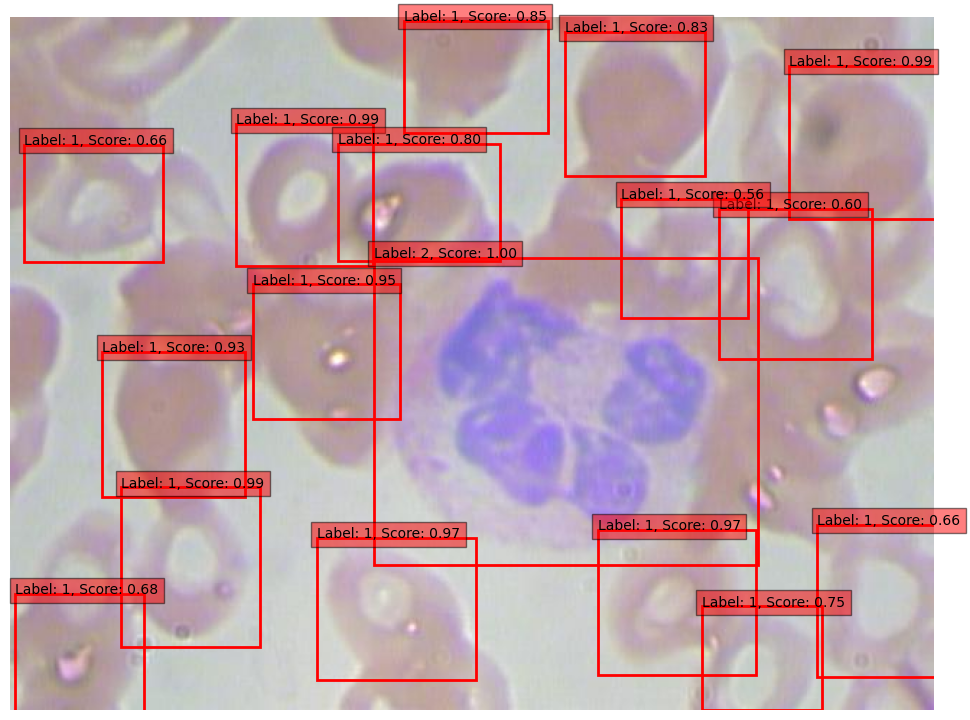

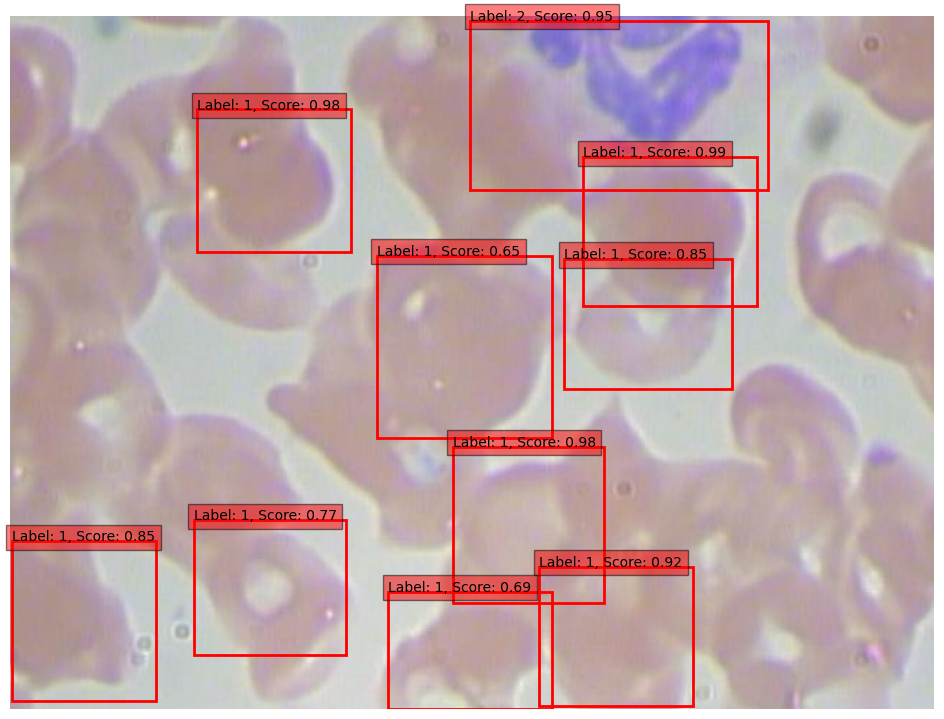

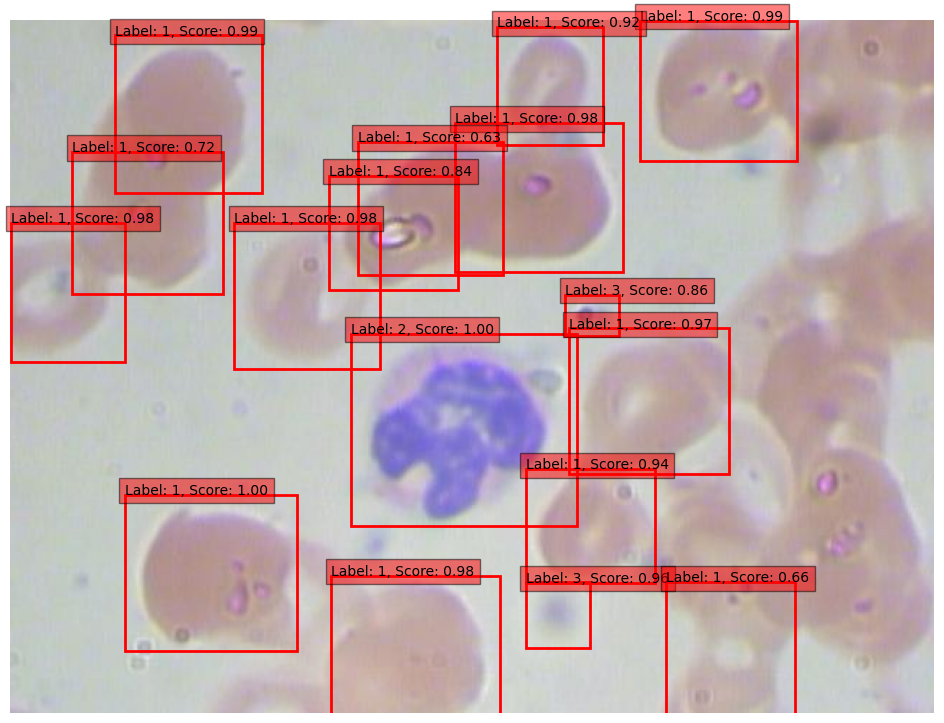

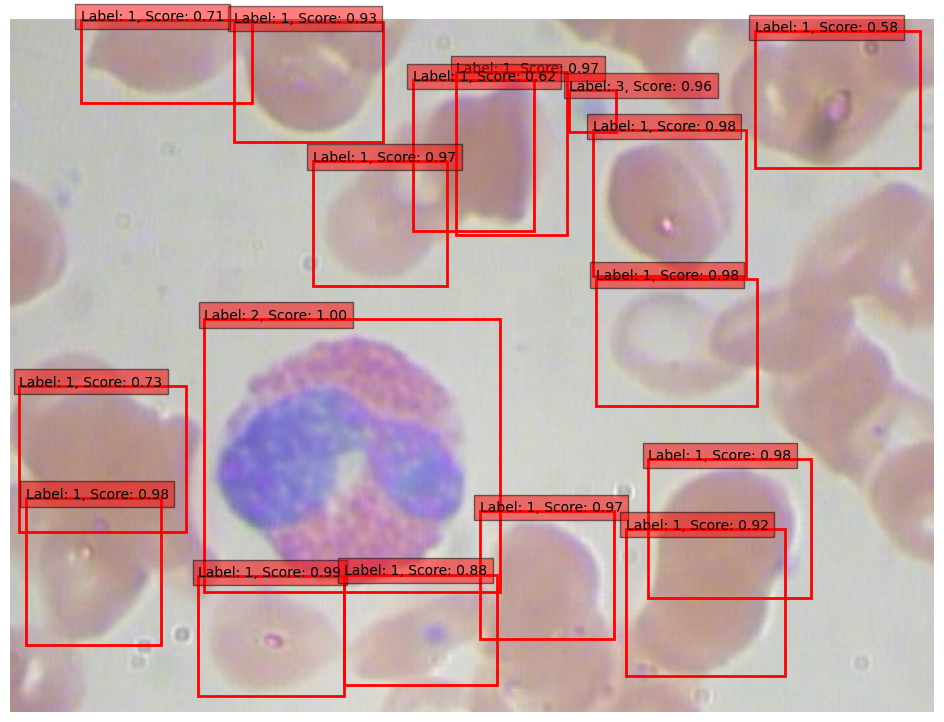

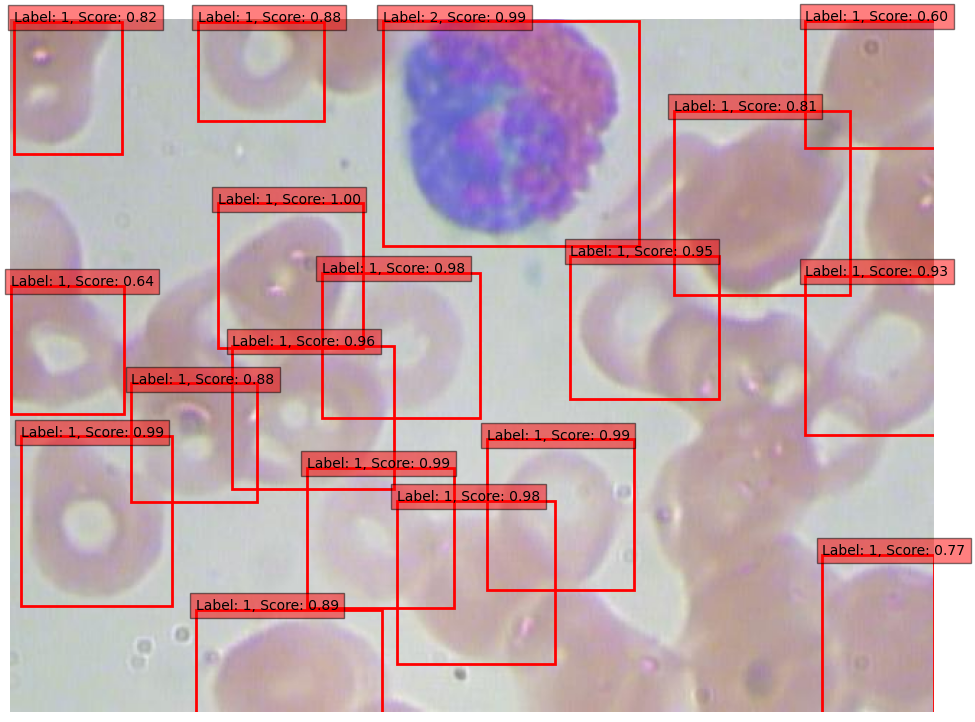

In [69]:
visualize_model_predictions_on_val_set(model, val_loader, device, num_images=5)